In [ ]:
# 1. mobilenet load, feature extractor 사용
# global average pooling, dense layer 연결
# mobilenet freeze --> train

# 2. cam 이미지 출력

# 3. 4 channel 이미지를 input으로 받는 모델 설계, 학습

# 4. 이미지와 기타 특성들을 input으로 받는 모델 설계

# 5. 6개의 input을 받을 수 있게 layer 정의, 모델 설계

# 6. 5번 잘 풀었으면 학습하고 print만 하면 됨

# 7. callback class 정의
# best val_acc 모델 저장, 10 epoch 마다 평가
# early stopping, val_loss, 2번 이상 개선 없으면 stop

## MobileNet 의 feature extractor를 사용하여 모델 설계
- feature extractor의 parameter 고정
- GlobalAveragePooling, Dense layer 추가
- 학습

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Concatenate, Dense, GlobalAveragePooling2D, AveragePooling2D

In [2]:
!pip install tensorflow_datasets

In [3]:
import tensorflow_datasets as tfds

In [4]:
dataset_name = 'cats_vs_dogs'
train_data, test_data = tfds.load(name=dataset_name, split=('train[:80%]', 'train[80%:]'), as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteW6GNS4/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [5]:
def preprocess(img, lbl):
    _img = tf.cast(img, tf.float32)
    _img = tf.divide(_img, 255)
    _img = tf.image.resize(_img, (150, 150))

    return _img, lbl

In [6]:
train_databatch = train_data.map(preprocess).batch(32).repeat()
test_databatch = test_data.map(preprocess).batch(32).repeat()

In [ ]:
pretrained_mobilenet.summary()

In [9]:
###############################
pretrained_mobilenet = tf.keras.applications.MobileNetV2(input_shape=(150,150,3), weights='imagenet', include_top=False)
feat_ext = Model(pretrained_mobilenet.input, pretrained_mobilenet.layers[-1].output)
###############################
# feat_ext.summary()

In [10]:
###############################
inp = Input(shape=(150,150,3))
x = feat_ext(inp)
x = GlobalAveragePooling2D()(x)
out = Dense(2, activation='softmax')(x)
model1 = Model(inp, out)
###############################
# model1.summary()

In [11]:
print(model1.layers[1].trainable)
###############################
feat_ext.trainable = False
###############################
print(model1.layers[1].trainable)

True
False


In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [14]:
###############################
model1.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics='acc')
model1.fit(
      train_databatch, 
      steps_per_epoch=10,
      epochs=3,
      validation_data=(test_databatch),
      validation_steps=(len(test_data)/32))
###############################


Epoch 1/3
10/10 [==============================] - 38s 866ms/step - loss: 1.2764 - acc: 0.5031 - val_loss: 0.4314 - val_acc: 0.8216
Epoch 2/3
10/10 [==============================] - 7s 789ms/step - loss: 0.2723 - acc: 0.8969 - val_loss: 0.2636 - val_acc: 0.8923
Epoch 3/3
10/10 [==============================] - 7s 798ms/step - loss: 0.2066 - acc: 0.9250 - val_loss: 0.1622 - val_acc: 0.9331


## CAM 이미지 출력 (Explainable AI)
- 주어진 함수 작성 완료
- sample 이미지에 대해 cam 이미지 출력

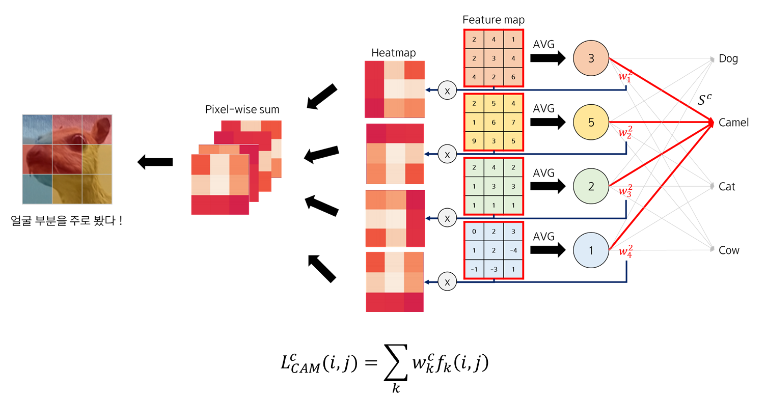

In [15]:
###############################
weights = model1.layers[-1].weights[0]
###############################
weights.shape

TensorShape([1280, 2])

In [16]:
import matplotlib.pyplot as plt
def display_cam(img, feature, result) :
  plt.imshow(img)
  plt.show()

  height, width = img.shape[:2]

  ###############################
  pred = tf.argmax(result)
  ###############################

  ###############################
  pred_weights = weights[:,pred]
  ###############################
  
  resized_feature = tf.image.resize(feature, (height, width))
  
  ###############################
  weighted_feature = pred_weights*resized_feature
  cam_heatmap = tf.math.reduce_sum(weighted_feature, axis=-1)
  ###############################

  plt.imshow(cam_heatmap, cmap='Reds')
  plt.show()

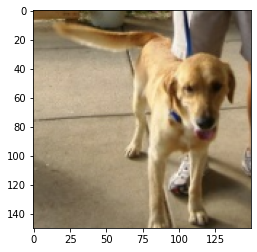

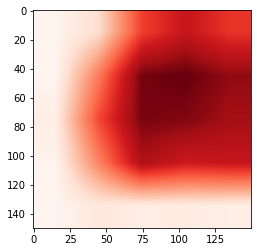

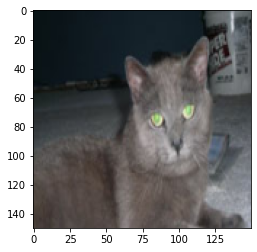

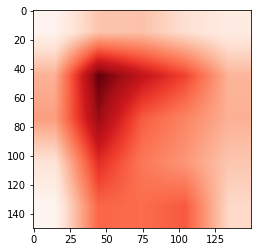

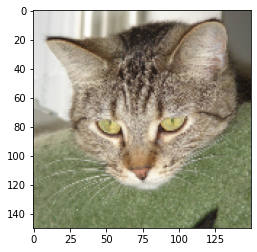

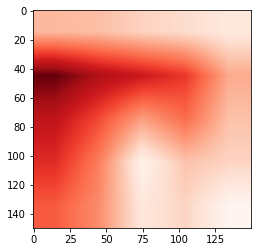

In [17]:
for x, y  in test_databatch.take(3) :
  sample_img = x[0]
  sample_img = tf.expand_dims(sample_img, axis=0)
  ###############################
  feature = feat_ext(sample_img)[0]
  result = model1(sample_img)[0]
  display_cam(sample_img[0], feature, result)
  ###############################

## 4-channel data를 input으로 받는 모델 설계, 학습
- regression
- preprocess
- conv, avgpool, concat, dense


In [1]:
import numpy as np
train_img = np.random.randn(3200,32,32,1)
train_img.shape

(3200, 32, 32, 1)

In [14]:
###############################
# train_x = train_img.reshape(800,32,32,4)
train_x = train_img.reshape(800,4,32,32)
train_x = np.rollaxis(train_x, 1, 4)
###############################
train_x.shape

(800, 32, 32, 4)

In [15]:
train_img[:4].mean(), train_x[0].mean()

(0.007755869638417217, 0.007755869638417217)

In [17]:
train_img[0].mean()==train_x[0,:,:,0].mean(), train_img[3].mean()==train_x[0,:,:,3].mean()

(True, True)

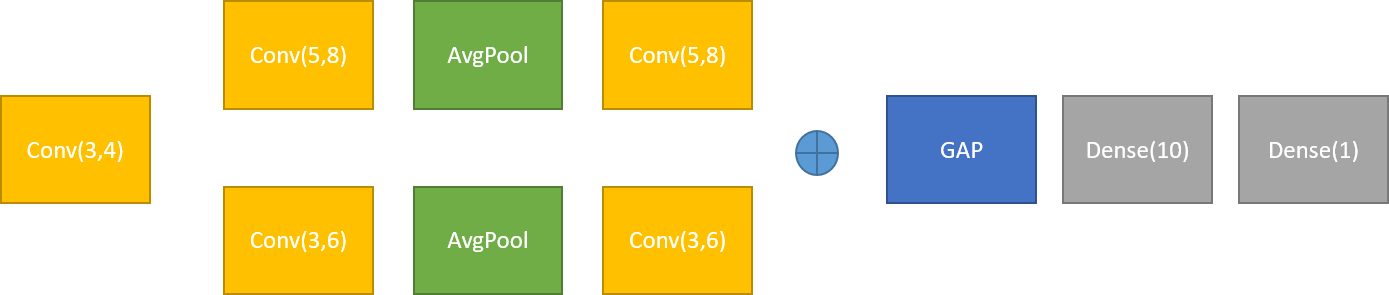

In [22]:
###############################
inp = Input(shape=(32,32,4))
x = Conv2D(12, 7, padding='same')(inp)

x1 = Conv2D(8, 5, padding='same')(x)
x1 = AveragePooling2D(strides=1, padding='same')(x1)
x1 = Conv2D(8, 5, padding='same')(x1)

x2 = Conv2D(6, 3, padding='same')(x)
x2 = AveragePooling2D(strides=1, padding='same')(x2)
x2 = Conv2D(6, 3, padding='same')(x2)

x = Concatenate(axis=-1)([x1,x2])
x = GlobalAveragePooling2D()(x)
x = Dense(10)(x)
out = Dense(1, activation='relu')(x)
model2 = Model(inp, out)
###############################
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 12)   2364        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 8)    2408        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 6)    654         conv2d[0][0]                     
____________________________________________________________________________________________

In [138]:
model2.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
model2.fit(train_x~~~)

### 이미지 외의 feature도 input으로 받을 수 있는 모델 설계
- preprocess
- reshape, concat

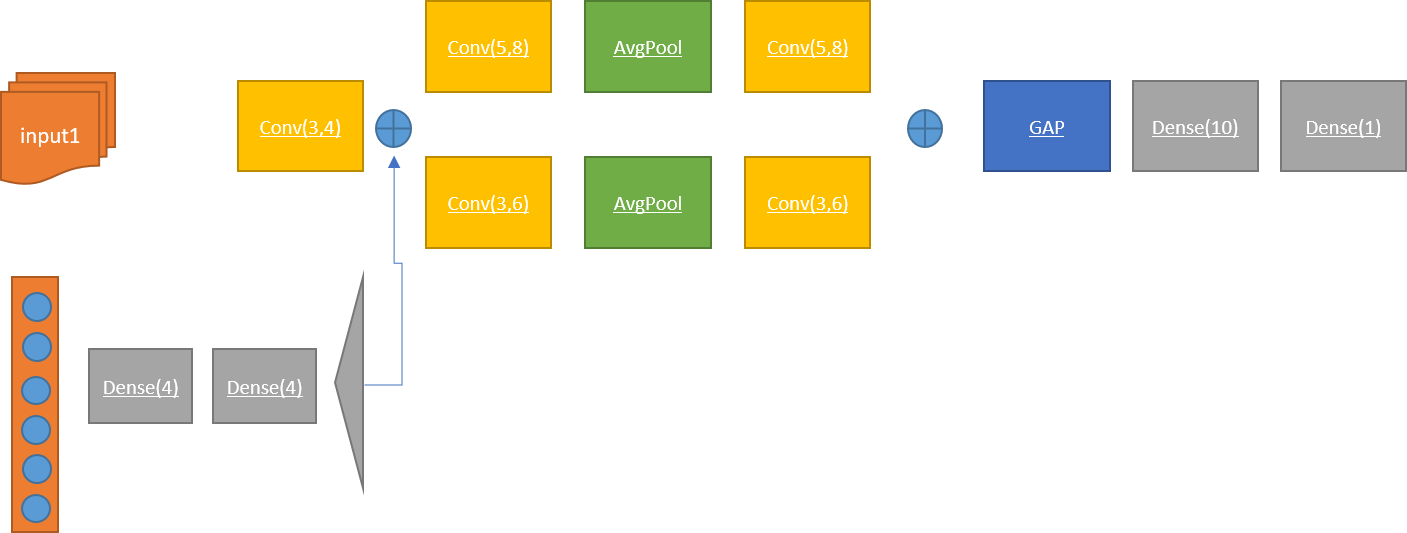

In [139]:
feat1 = np.random.randn(800,1)
feat2 = np.random.randn(800,1)
feat3 = np.random.randn(800,1)
feat4 = np.random.randn(800,1)
feat5 = np.random.randn(800,1)
feat6 = np.random.randn(800,1)
feat1.shape, feat2.shape, feat3.shape, feat4.shape, feat5.shape, feat6.shape

((800, 1), (800, 1), (800, 1), (800, 1), (800, 1), (800, 1))

In [140]:
###############################
train_x = train_img.reshape(800,4,32,32)
train_x = np.rollaxis(train_x, 1, 4)
train_feat = np.concatenate((feat1, feat2, feat3, feat4, feat5, feat6), axis=1)
###############################
train_x.shape, train_feat.shape

((800, 32, 32, 4), (800, 6))

In [23]:
###############################
inp1 = Input(shape=(32,32,4))
x1 = Conv2D(12, 7, padding='same')(inp1)

inp2 = Input(shape=(6))
x2 = Dense(4)(inp2)
x2 = Dense(4)(x2)
x2 = tf.keras.layers.Reshape((1,1,4))(x2)
x2 = tf.keras.layers.UpSampling2D((32,32))(x2)

x = Concatenate(axis=-1)([x1,x2])

x1 = Conv2D(8, 5, padding='same')(x)
x1 = AveragePooling2D(strides=1, padding='same')(x1)
x1 = Conv2D(8, 5, padding='same')(x1)

x2 = Conv2D(6, 3, padding='same')(x)
x2 = AveragePooling2D(strides=1, padding='same')(x2)
x2 = Conv2D(6, 3, padding='same')(x2)

x = Concatenate(axis=-1)([x1,x2])
x = GlobalAveragePooling2D()(x)
x = Dense(10)(x)
out = Dense(1, activation='relu')(x)
model3 = Model([inp1, inp2], out)
###############################
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 4)            28          input_6[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 4)            20          dense_3[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 32, 32, 4)]  0                                            
____________________________________________________________________________________________

In [ ]:
###############################
model3.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
model3.fit([train_x, train_feat], )
###############################

### 6개의 input을 받을 수 있게 모델 설계
- embedding 4개, continuous 변수 2개
- concat

In [24]:
from tensorflow.keras.layers import Embedding

In [ ]:
inp = Input(shape=(None,6))
###############################
x1 = Embedding(841,30)(inp[:,:,0])
x2 = Embedding(243,30)(inp[:,:,1])
x3 = Embedding(90,30)(inp[:,:,2])
x4 = Embedding(78,30)(inp[:,:,3])
x5 = tf.expand_dims(inp[:,:,4]/120, axis=-1) ## 0~120 범위일 때 0~1로 normalize
x6 = tf.expand_dims((inp[:,:,5]-60)/120, axis=-1) ## 60~180 범위일 때 0~1로 normalize
###############################

x = Concatenate(axis=-1)([x1,x2,x3,x4,x5,x6])
x = Dense(10)(x)
out = Dense(2, activation='softmax')(x)
model4 = Model(inp, out)
model4.summary()

### train 후 threshold 0.93, 0.95 이상인 영화제목 출력

### callback 정의
- model checkpoint : 10 epoch 마다 val_acc가 높은 모델 저장
- early stopping : val_loss 기준으로 2 epoch 동안 개선이 없으면 
- custom class로 정의

In [ ]:
# tf.keras.callbacks.ModelCheckpoint(
#     filepath, monitor='val_loss', verbose=0, save_best_only=False,
#     save_weights_only=False, mode='auto', save_freq='epoch',
#     options=None, **kwargs
# )

In [ ]:
# tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', min_delta=0, patience=0, verbose=0,
#     mode='auto', baseline=None, restore_best_weights=False
# )

In [26]:
callback1 = tf.keras.callbacks.ModelCheckpoint('./custom_model.h5', monitor='val_acc', save_best_only=True, save_freq=10)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
custom_callback = [callback1, callback2]
model4.fit(________________________,
           callbacks=custom_callback)

In [158]:
class MY_CB(tf.keras.callbacks.Callback) :
  def on_train_begin(self, logs=None):
      keys = list(logs.keys())
      print("Starting training; got log keys: {}".format(keys))

  def on_train_end(self, logs=None):
      keys = list(logs.keys())
      print("Stop training; got log keys: {}".format(keys))

  def on_epoch_begin(self, epoch, logs=None):
      keys = list(logs.keys())
      print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

  def on_epoch_end(self, epoch, logs=None):
      keys = list(logs.keys())
      print("End epoch {} of training; got log keys: {}".format(epoch, keys))

  def on_test_begin(self, logs=None):
      keys = list(logs.keys())
      print("Start testing; got log keys: {}".format(keys))

  def on_test_end(self, logs=None):
      keys = list(logs.keys())
      print("Stop testing; got log keys: {}".format(keys))

  def on_predict_begin(self, logs=None):
      keys = list(logs.keys())
      print("Start predicting; got log keys: {}".format(keys))

  def on_predict_end(self, logs=None):
      keys = list(logs.keys())
      print("Stop predicting; got log keys: {}".format(keys))

  def on_train_batch_begin(self, batch, logs=None):
      keys = list(logs.keys())
      print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

  def on_train_batch_end(self, batch, logs=None):
      keys = list(logs.keys())
      print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

  def on_test_batch_begin(self, batch, logs=None):
      keys = list(logs.keys())
      print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

  def on_test_batch_end(self, batch, logs=None):
      keys = list(logs.keys())
      print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

  def on_predict_batch_begin(self, batch, logs=None):
      keys = list(logs.keys())
      print("...Predicting: start of batch {}; got log keys: {}".format(batch, keys))

  def on_predict_batch_end(self, batch, logs=None):
      keys = list(logs.keys())
      print("...Predicting: end of batch {}; got log keys: {}".format(batch, keys))